In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from tempfile import mkdtemp
from shutil import rmtree

In [2]:
data = pd.read_csv('train.csv', index_col=0)
data.head()

,content,category
id,,
SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


# 1. Basic EDA

> The classes are heavily imbalanced. `Kimataifa` and `Burudani` are too under-represented.

<AxesSubplot:xlabel='category', ylabel='count'>

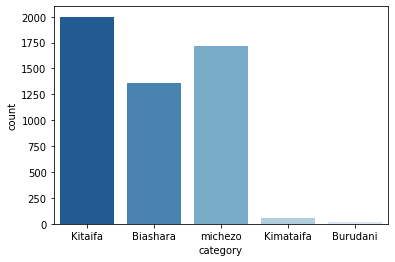

In [3]:
sns.countplot(x=data['category'], palette='Blues_r')

(-0.5, 599.5, 399.5, -0.5)

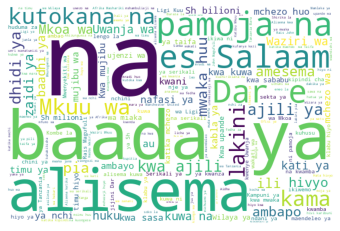

In [4]:
wordcloud = WordCloud(width=600, height=400, background_color='#fff').generate(data['content'].to_csv())
plt.imshow(wordcloud)
plt.axis("off")

In [5]:
stop_words = {
    'moja', 'mbili', 'tatu', 'nne', 'tano', 'sita', 'saba', 'nane', 'tisa', 'kumi',
    'ishirini', 'thelathini', 'arobaine', 'hamsini', 'sitini', 'sabini',
    'themanini', 'tisini', 'mia', 'elfu', 'laki', 'nusu', 'hapa', 'pale', 'kule',
    'baada', 'cha',  'hadi', 'hao', 'hayo', 'hicho', 'hilo', 'hivyo', 'hiyo',
    'huku', 'huo', 'kwenye', 'huu', 'huyo', 'hizo', 'ili', 'jana', 'kama', 'katika',
    'kila', 'kutoka', 'kuwa', 'kwa', 'kwamba', 'la', 'lakini', 'na', 'ni',
    'pia', 'sasa', 'taarifa', 'vya', 'wa', 'ya', 'yao', 'za', 'zao'
}

# 2. Model Fitting

In [6]:
X = data['content']
y = data['category']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=4)

random_oversampler = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = random_oversampler.fit_resample(
    X_train.to_frame(), y_train
)

def fit_and_evaluate(model, param_grid):
    """Perform a grid search and get the best model.
    
    Parameters
    ----------
    model : sklearn classifier
        Classification model
    param_grid : dict
        Hyper-parameter values to test

    Returns
    -------
    best_model : sklearn classifier
        The model fitted with the best blend of hyper-parameters
    """    
    cache_dir = mkdtemp()
    param_grid = param_grid or {}

    model_pipeline = Pipeline(memory=cache_dir, steps=[
        ('vectorize', TfidfVectorizer(ngram_range=(1, 2), stop_words=stop_words)),
        ('clf', model)
    ])
    model_search = GridSearchCV(
        model_pipeline, param_grid, n_jobs=4, verbose=1, scoring='f1_micro'
    )
    model_search.fit(X_train_resampled["content"], y_train_resampled)
    print(classification_report(y_valid, model_search.predict(X_valid),
                                zero_division=0))
    rmtree(cache_dir)
    return model_search.best_estimator_

## 2.1 Multinomial Naive Bayes

In [7]:
param_grid = {
    'clf__alpha': np.logspace(-5, -2, 8)
}
mnb = MultinomialNB()
mnb_model = fit_and_evaluate(mnb, param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/tim/Data_Science/venv/lib/python3.8/site-packages/sklearn/pipeline.py:303: UserWarning: Persisting input arguments took 3.00s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


              precision    recall  f1-score   support

    Biashara       0.80      0.82      0.81       328
    Burudani       0.00      0.00      0.00         7
   Kimataifa       0.00      0.00      0.00         8
     Kitaifa       0.83      0.85      0.84       523
     michezo       0.95      0.92      0.94       422

    accuracy                           0.86      1288
   macro avg       0.52      0.52      0.52      1288
weighted avg       0.85      0.86      0.85      1288



## 2.2 Linear SVM

In [8]:
param_grid = {
    'clf__alpha': np.logspace(-4, 0, 10)
}
svc = SGDClassifier(class_weight='balanced', loss='modified_huber',
                    penalty='elasticnet', random_state=9)
svc_model = fit_and_evaluate(svc, param_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/tim/Data_Science/venv/lib/python3.8/site-packages/sklearn/pipeline.py:303: UserWarning: Persisting input arguments took 3.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


              precision    recall  f1-score   support

    Biashara       0.80      0.80      0.80       328
    Burudani       0.00      0.00      0.00         7
   Kimataifa       0.50      0.12      0.20         8
     Kitaifa       0.85      0.84      0.84       523
     michezo       0.94      0.97      0.95       422

    accuracy                           0.86      1288
   macro avg       0.62      0.55      0.56      1288
weighted avg       0.86      0.86      0.86      1288



# 3. Create Submission File

In [9]:
test = pd.read_csv('test.csv', index_col=0)
test.head()

,content
swahili_id,
001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"MKUU wa Wilaya ya Bahi, Mkoani Dodoma, Mwanah..."
0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"MWISHONI mwa wiki hii, Timu ya Soka ya Taifa,..."
00579c2307b5c11003d21c40c3ecff5e922c3fd8,THAMANI ya mauzo ya bidhaa za Afrika Masharik...
00868eeee349e286303706ef0ffd851f39708d37,MENEJA Mawasiliano na Utetezi wa asasi ya AGP...
00a5cb12d3058dcf2e42f277eee599992db32412,"WAZIRI wa Kilimo, Japhet Hasunga amesema seri..."


In [10]:
preds = svc_model.predict_proba(test['content'])
preds

array([[0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.74216206, 0.        , 0.        , 0.25783794, 0.        ],
       ...,
       [0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.0708131 , 0.9291869 ],
       [0.00571522, 0.        , 0.        , 0.99428478, 0.        ]])

In [11]:
svc_model.classes_

array(['Biashara', 'Burudani', 'Kimataifa', 'Kitaifa', 'michezo'],
      dtype='<U9')

In [12]:
sub = pd.DataFrame({'kitaifa': preds[:, 3], 'michezo': preds[:, 4],
                    'biashara': preds[:, 0], 'kimataifa': preds[:, 2],
                    'burudani': preds[:, 1]}, index=test.index)
sub.head()

,kitaifa,michezo,biashara,kimataifa,burudani
swahili_id,,,,,
001dd47ac202d9db6624a5ff734a5e7dddafeaf2,1.000000,0.000000,0.000000,0.000000,0.000000
0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0.000000,1.000000,0.000000,0.000000,0.000000
00579c2307b5c11003d21c40c3ecff5e922c3fd8,0.257838,0.000000,0.742162,0.000000,0.000000
00868eeee349e286303706ef0ffd851f39708d37,0.697595,0.039444,0.000000,0.261173,0.001788
00a5cb12d3058dcf2e42f277eee599992db32412,0.509978,0.000000,0.490022,0.000000,0.000000


In [13]:
sub.to_csv('sub2.csv')